In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('jazz.csv', sep='|')

In [3]:
# Define features to analyze
features = [
            'danceability',
            'energy',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'num_samples',
            'end_of_fade_in',
            'start_of_fade_out',
            'loudness',
            'tempo',
            'key',
            'mode',
            'bars_num',
            'bars_duration_mean',
            'bars_duration_var',
            'beats_num',
            'beats_duration_mean',
            'beats_duration_var',
            'sections_num',
            'sections_duration_mean',
            'sections_duration_var',
            'loudness_var',
            'tempo_var',
            'key_var',
            'mode_var',
            'segments_num',
            'segments_duration_var',
            'segments_duration_mean',
            'pitches_mean',
            'pitches_var',
            'timbre_mean',
            'timbre_var',
            'tatums_num',
            'tatums_duration_mean',
            'tatums_duration_var'
           ]

feat_df = df[features].copy()

## Data contains features that are likely correlated to various degrees, for example number of bars and beats. Let's therefore start the analysis by looking at correlations

In [4]:
# Heatmap functions for correlation analysis taken (with slight modifications) from this article:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
# Making into class of correlation functions

class CorrAnalysis():

    def heatmap(self, x, y, **kwargs):
        
        if 'color' in kwargs:
            color = kwargs['color']
        else:
            color = [1]*len(x)
    
        if 'palette' in kwargs:
            palette = kwargs['palette']
            n_colors = len(palette)
        else:
            n_colors = 256 # Use 256 colors for the diverging color palette
            palette = sns.color_palette("Blues", n_colors) 
            
        # Range of values that will be mapped to the palette, i.e. min and max possible correlation
        if 'color_range' in kwargs:
            color_min, color_max = kwargs['color_range']
        else:
            color_min, color_max = min(color), max(color) 
    
        def value_to_color(val):
            '''Get the color from color palette based on color value.'''
            if color_min == color_max:
                return palette[-1]
            else:
                # position of value in the input range, relative to the length of the input range
                val_position = float((val - color_min)) / (color_max - color_min) 
                # bound the position betwen 0 and 1
                val_position = min(max(val_position, 0), 1) 
                # target index in the color palette
                ind = int(val_position * (n_colors - 1)) 
                return palette[ind]
    
        if 'size' in kwargs:
            size = kwargs['size']
        else:
            size = [1]*len(x)
    
        if 'size_range' in kwargs:
            size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
        else:
            size_min, size_max = min(size), max(size)
        size_scale = kwargs.get('size_scale', 500)
    
        def value_to_size(val):
            '''Get size of marker based on size value and size scale'''
            
            if size_min == size_max:
                return 1 * size_scale
            else:
                # position of value in the input range, relative to the length of the input range
                val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 
                # bound the position betwen 0 and 1
                val_position = min(max(val_position, 0), 1) 
                return val_position * size_scale
            
        if 'x_order' in kwargs: 
            x_names = [t for t in kwargs['x_order']]
        else:
            x_names = [t for t in sorted(set([v for v in x]))]
        x_to_num = {p[1]:p[0] for p in enumerate(x_names)}
    
        if 'y_order' in kwargs: 
            y_names = [t for t in kwargs['y_order']]
        else:
            y_names = [t for t in sorted(set([v for v in y]))]
        y_to_num = {p[1]:p[0] for p in enumerate(y_names)}
    
        plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
        ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot
    
        marker = kwargs.get('marker', 's')
    
        kwargs_pass_on = {
                          k:v for k,v in kwargs.items() if k not in [
                                                                     'color',
                                                                     'palette',
                                                                     'color_range',
                                                                     'size',
                                                                     'size_range',
                                                                     'size_scale',
                                                                     'marker',
                                                                     'x_order',
                                                                     'y_order'
                                                                    ]
                         }
    
        ax.scatter(
                   x = [x_to_num[v] for v in x],
                   y = [y_to_num[v] for v in y],
                   marker = marker,
                   s = [value_to_size(v) for v in size], 
                   c = [value_to_color(v) for v in color],
                   **kwargs_pass_on
                  )
        ax.set_xticks([v for k,v in x_to_num.items()])
        ax.set_xticklabels([k for k in x_to_num], rotation=90, horizontalalignment='right')
        ax.set_yticks([v for k,v in y_to_num.items()])
        ax.set_yticklabels([k for k in y_to_num])
        # Move squares to cell center
        ax.grid(False, 'major')
        ax.grid(True, 'minor')
        ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
        ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)
        # Fix x and y lims to center squares properly
        ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
        ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
        ax.set_facecolor('#F1F1F1')
    
        # Add color legend on the right side of the plot
        if color_min < color_max:
            # Use the rightmost column of the plot
            ax = plt.subplot(plot_grid[:,-1]) 
            # Fixed x coordinate for the bars
            col_x = [0]*len(palette)
            # y coordinates for each of the n_colors bars
            bar_y = np.linspace(color_min, color_max, n_colors) 
    
            bar_height = bar_y[1] - bar_y[0]
            ax.barh(
                    y = bar_y,
                    width = [5]*len(palette), # Make bars 5 units wide
                    left = col_x, # Make bars start at 0
                    height = bar_height,
                    color = palette,
                    linewidth = 0
                   )
            # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
            ax.set_xlim(1, 2)
            # Hide grid
            ax.grid(False) 
            # Make background white
            ax.set_facecolor('white')
            # Remove horizontal ticks
            ax.set_xticks([]) 
            # Show vertical ticks for min, middle, and max
            ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) 
            # Show vertical ticks on the right 
            ax.yaxis.tick_right() 


    def corrplot(self, data, size_scale=500, marker='s'):
        '''Create correlation plot of dataframe data.'''
        
        corr = pd.melt(data.reset_index(), id_vars='index')
        corr.columns = ['x', 'y', 'value']
        self.heatmap(
                     corr['x'], 
                     corr['y'],
                     color = corr['value'],
                     color_range = [-1, 1],
                     palette = sns.diverging_palette(20, 220, n=256),
                     size = corr['value'].abs(),
                     size_range = [0,1],
                     marker = marker,
                     x_order = data.columns,
                     y_order = data.columns[::-1],
                     size_scale = size_scale
                    )

CorrAnalysis = CorrAnalysis()

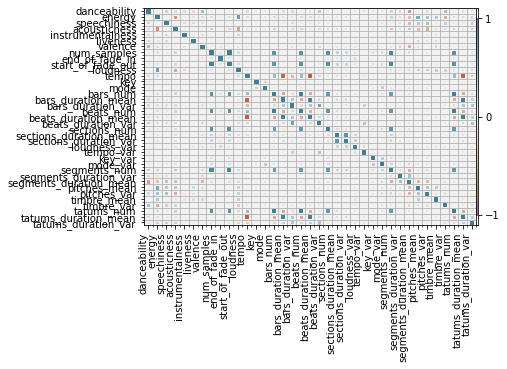

In [5]:
# Labels are a bit tough to read due to number of features, but can see that some features are highly correlated
# Tempo is negatively correlated with bars, beats, and tatums duration, and number of samples is correlated with 
# start of fade out. Lastly tatums_num seem to be correlated with a number of features as well.
CorrAnalysis.corrplot(feat_df.corr(), size_scale=10)

In [6]:
# Look closer at correlation values for bars, beats, and tatums duration with each other and tempo.

tempo_df = df[['tempo', 'bars_duration_mean', 'beats_duration_mean', 'tatums_duration_mean']].corr()

tempo_df.head()

,tempo,bars_duration_mean,beats_duration_mean,tatums_duration_mean
tempo,1.000000,-0.926696,-0.948389,-0.948216
bars_duration_mean,-0.926696,1.000000,0.972126,0.972011
beats_duration_mean,-0.948389,0.972126,1.000000,0.999994
tatums_duration_mean,-0.948216,0.972011,0.999994,1.000000


Tempo is very highly correlated with bars, duration, and tatums duration. Can probably safely remove these features from dataset and keep only tempo. 

In [7]:
# Look closer at fade in and number of samples
fade_df = df[['start_of_fade_out', 'num_samples']].corr()

fade_df.head()

,start_of_fade_out,num_samples
start_of_fade_out,1.000000,0.998711
num_samples,0.998711,1.000000


Can safely remove start_of_fade_out as well.

In [8]:
# Look closer at tatums number correlations
tatums_df = df[['tatums_num', 'segments_num', 'sections_num', 'beats_num', 'bars_num', 'num_samples']].corr()

tatums_df.head(10)

,tatums_num,segments_num,sections_num,beats_num,bars_num,num_samples
tatums_num,1.000000,0.785029,0.787845,1.000000,0.986697,0.851102
segments_num,0.785029,1.000000,0.810114,0.785029,0.761477,0.930434
sections_num,0.787845,0.810114,1.000000,0.787840,0.777093,0.872527
beats_num,1.000000,0.785029,0.787840,1.000000,0.986699,0.851100
bars_num,0.986697,0.761477,0.777093,0.986699,1.000000,0.835923
num_samples,0.851102,0.930434,0.872527,0.851100,0.835923,1.000000


Can remove tatums_num, beats_num, and segments_num as well, based on correlation >0.9 with bars_num or num_samples

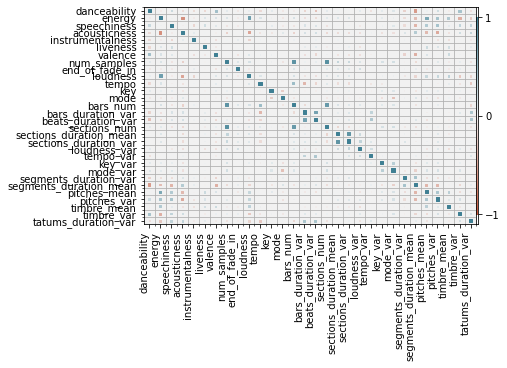

In [9]:
cols_to_drop = [
                'start_of_fade_out',
                'bars_duration_mean',
                'beats_duration_mean',
                'tatums_duration_mean',
                'tatums_num',
                'beats_num',
                'segments_num'
               ]

feat_df.drop(
             cols_to_drop,
             axis = 1,
             inplace = True
            )

CorrAnalysis.corrplot(feat_df.corr(), size_scale=10)

## Now let's take a look at the distribution of the remaining features

C:\Users\Alexander\anaconda3\envs\playlistenv\lib\site-packages\seaborn\axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


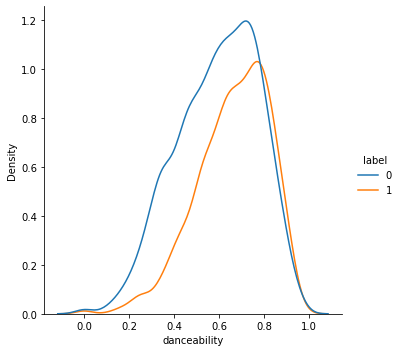

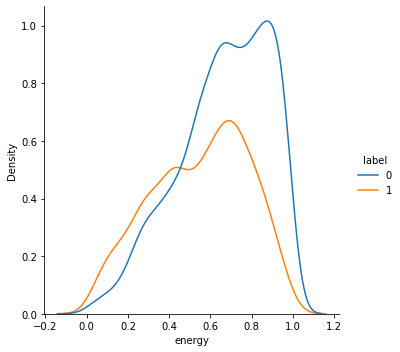

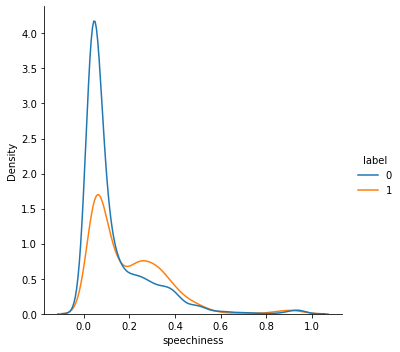

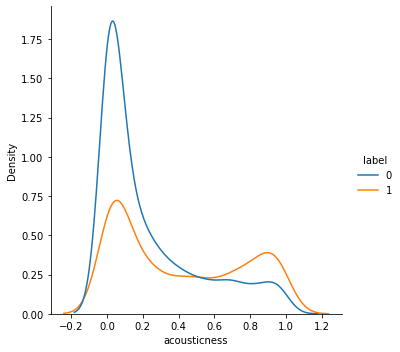

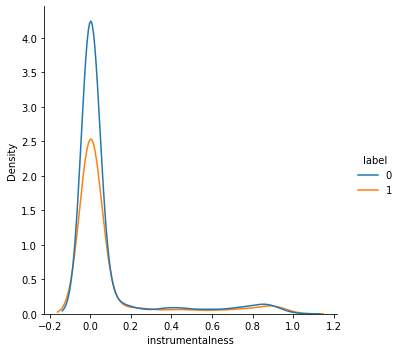

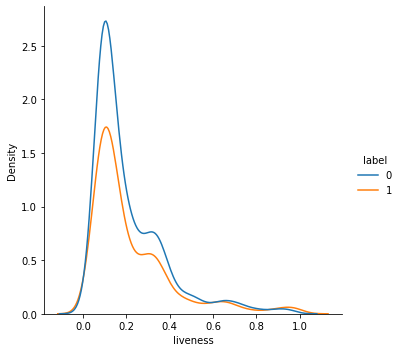

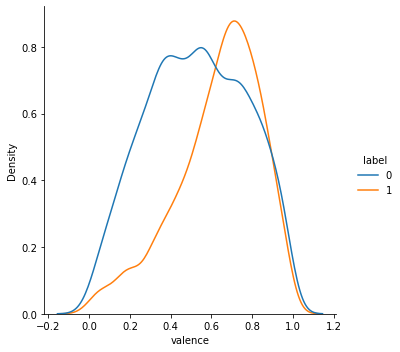

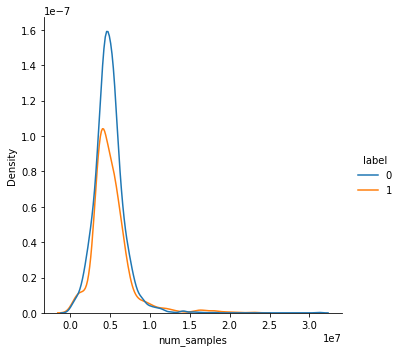

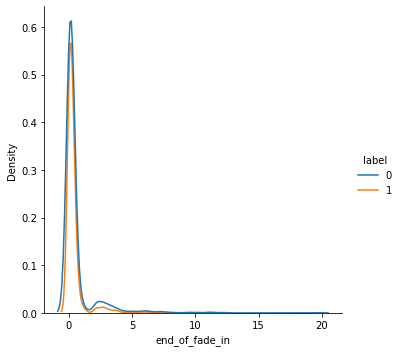

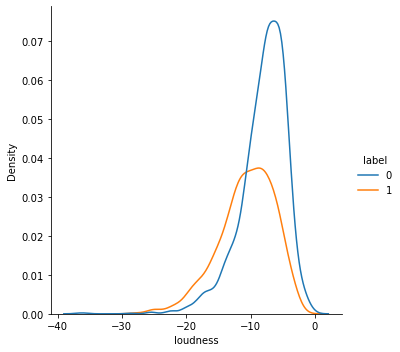

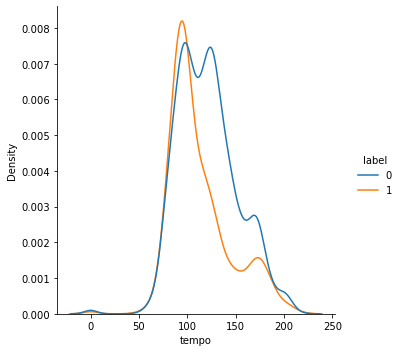

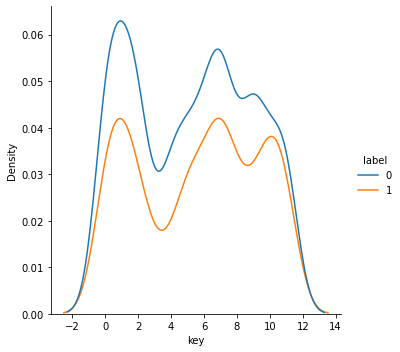

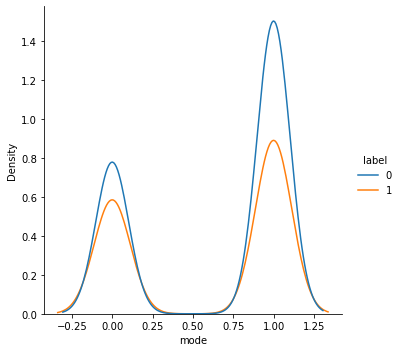

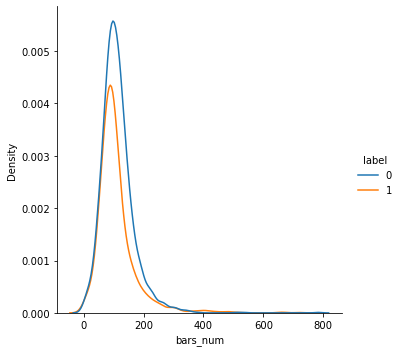

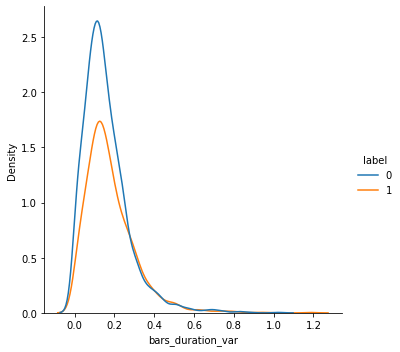

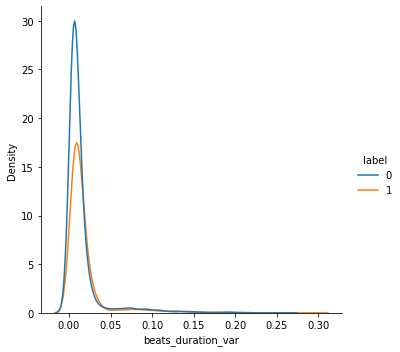

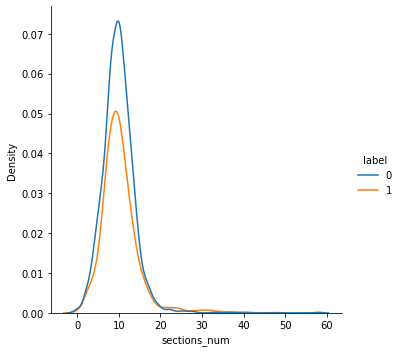

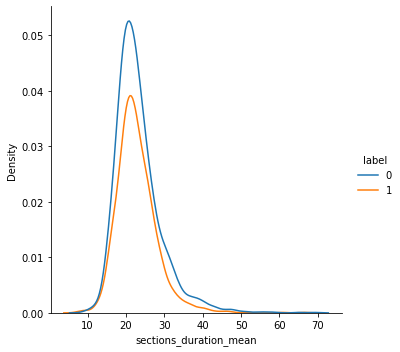

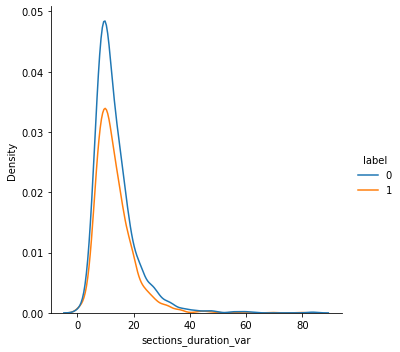

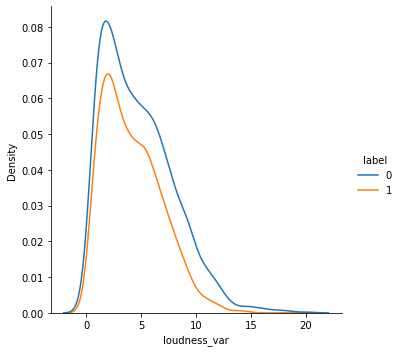

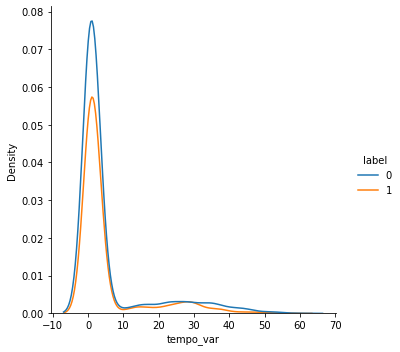

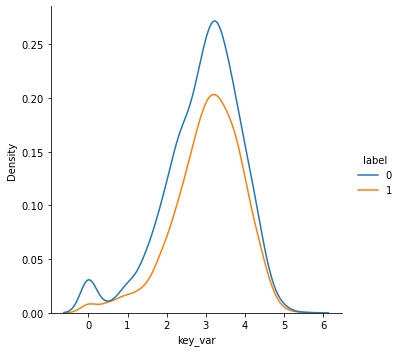

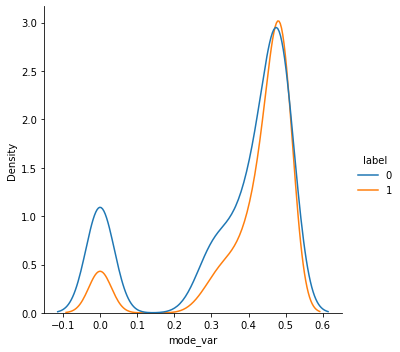

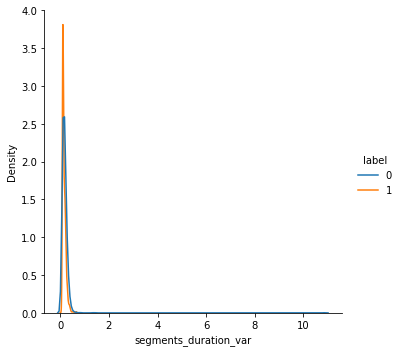

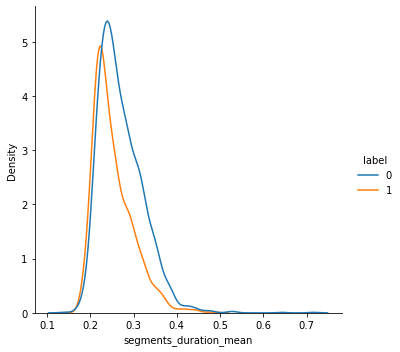

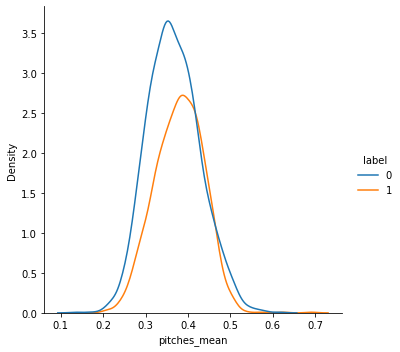

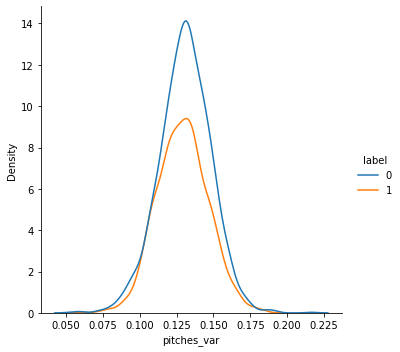

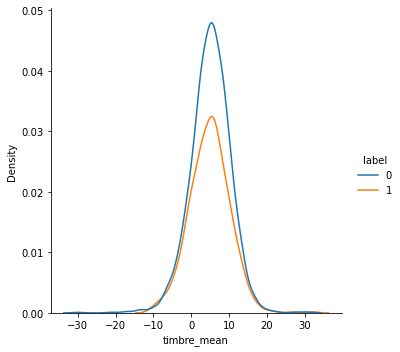

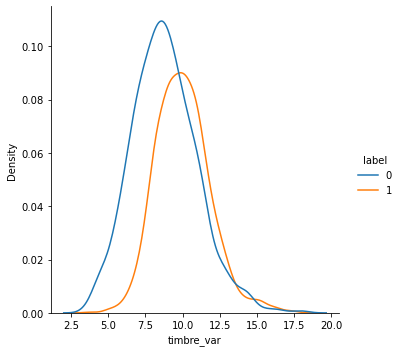

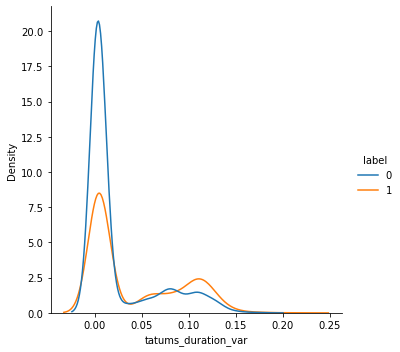

In [10]:
for col in [feat for feat in features if feat not in cols_to_drop]:
    sns.displot(df, x=col, kind='kde', hue='label')

end_of_fade_in, loudness, tempo, key, bars_num, sections_num, sections_duration_mean, sections_duration_var, loudness_var, tempo_var, key_var, segments_duration_var, timbre_mean, and timbre_var needs to be standardized if I want similar ranges for all variables. 

In [11]:
scale_feats = [
               'end_of_fade_in',
               'loudness', 
               'tempo',
               'key',
               'bars_num', 
               'sections_num',
               'sections_duration_mean',
               'sections_duration_var',
               'loudness_var',
               'tempo_var',
               'key_var',
               'segments_duration_var',
               'timbre_mean',
               'timbre_var'
              ]
train_feats = [f for f in features if f not in cols_to_drop]


## Now, let's see if we can see how the data cluster

This is for visualization, so I will do a PCA first to get the data down to 3 dimensions

In [12]:
# First standardize the features in need of standardization
scaler = Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

scaled_df = pd.DataFrame(scaler.fit_transform(feat_df), columns=train_feats)

In [13]:
pca = PCA(n_components = 3)
pca_model = pca.fit(scaled_df)
pca_df = pd.DataFrame(pca_model.transform(scaled_df), columns=['component_1', 'component_2', 'component_3'])\
           .join(df['label'])

In [14]:
explained_variance = pca_model.explained_variance_
print('Explained variances are {} for component 1, {} for component 2, and {} for component 3.'\
      .format(round(explained_variance[0], 2), round(explained_variance[1], 2), round(explained_variance[2], 2)))

Explained variances are 4.11 for component 1, 2.84 for component 2, and 2.68 for component 3.


In [15]:
var_ratios = pca_model.explained_variance_ratio_
print('Component 1 explains {}% of the variation, component 2 {}% of the variation, and component 3 {}% of the variation'\
      .format(round(var_ratios[0]*100, 0), round(var_ratios[1]*100, 0), round(var_ratios[2]*100, 0)))

Component 1 explains 14.0% of the variation, component 2 9.0% of the variation, and component 3 9.0% of the variation


Together the 3 top components that I plan to plot explains 32% of the variance, so the following plots will only give a small part of the story, but might give some indicators towards the linearity of the data.

<AxesSubplot:xlabel='component_2', ylabel='component_3'>

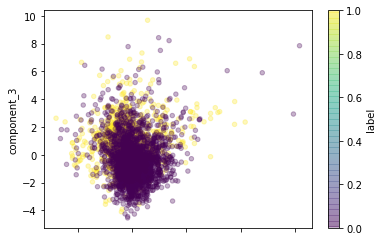

In [16]:
pca_df.plot.scatter('component_2', 'component_3', c='label', colormap='viridis', alpha=0.3)

Seems to be a lot of overlap, let's plot each label by themselves

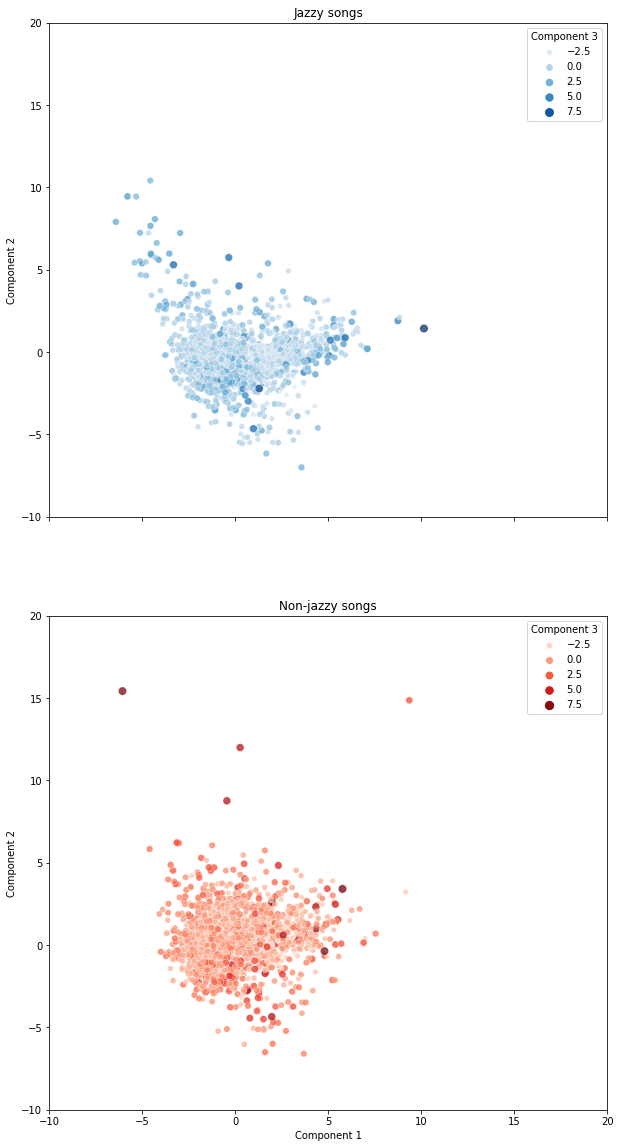

In [35]:
pos_df = pca_df[pca_df['label']==1].copy()
neg_df = pca_df[pca_df['label']==0].copy()

fig, axes = plt.subplots(2,1,figsize=(10,20), subplot_kw={'xlim': (-10,20), 'ylim': (-10, 20)}, sharex=True)
sns.scatterplot(
                data = pos_df,
                x = 'component_1',
                y = 'component_2',
                hue = 'component_3',
                size = 'component_3',
                palette = 'Blues',
                alpha = 0.75,
                ax = axes[0]
               )
axes[0].set_title('Jazzy songs')
axes[0].set_ylabel('Component 2')
axes[0].patch.set_alpha(1)
axes[0].legend(title='Component 3')
# plt.gca().set_aspect('equal', adjustable='box')
sns.scatterplot(
                data = neg_df,
                x = 'component_1',
                y = 'component_2',
                hue = 'component_3',
                size = 'component_3',
                palette = 'Reds',
                alpha = 0.75,
                ax = axes[1]
               )
axes[1].set_title('Non-jazzy songs')
axes[1].patch.set_alpha(1)
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')
axes[1].legend(title='Component 3')

Still significant overlap, but starting to see some differentiation at third dimension (component 3). So might be hope here to train a classifier. Classifier needs to be non-linear however. 